### Loading data

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
os.listdir('../input')

['quantinvestclassical', 'quantinvest']

In [3]:
import pandas as pd

prefix = '../input/quantinvest/'
FUNDS_CSV = prefix+'Quant_Invest_Fundusze.csv'
STOCKS_CSV = prefix+'all_indices_close.csv'
COMMODITIES_CSV = prefix+'all_commodities_close.csv'
RATES_CSV = prefix+'policy_rates.csv'
FX_CSV = prefix+'exchange_rates.csv'


def _load_indexed(path, index_col='Daty', sep=',') -> pd.DataFrame:
    df = pd.read_csv(path, index_col=index_col, sep=sep)
    df.index = pd.to_datetime(df.index)
    return df.sort_index()


def load_funds() -> pd.DataFrame:
    return _load_indexed(FUNDS_CSV, sep=';')


def load_stocks() -> pd.DataFrame:
    return _load_indexed(STOCKS_CSV, index_col='Data')


def load_commodities() -> pd.DataFrame:
    return _load_indexed(COMMODITIES_CSV, index_col='Data')


def load_rates() -> pd.DataFrame:
    policy_rates = pd.read_csv(RATES_CSV, index_col = 0)
    policy_rates = policy_rates.pivot(index='date', columns='reference_area', values='obs_value')
    policy_rates.index = pd.to_datetime(policy_rates.index)
    return policy_rates.iloc[:(-42)]  # keep only years 2000-2018


def load_fx() -> pd.DataFrame:
    exchange_rates = pd.read_csv(FX_CSV, index_col=0)
    exchange_rates.index = pd.to_datetime(exchange_rates['Date'])
    shortnames={}
    for col in exchange_rates.columns[1:]:
        start = col.index('(')
        end = col.index(')')
        shortnames[col] = col[(start+1):end]
    return exchange_rates.rename(columns = shortnames).drop(columns=['Date'])


def load_all() -> pd.DataFrame:
    return pd.concat([
        load_funds(),
        load_stocks(),
        load_commodities(),
        load_rates(),
        load_fx()
    ], axis='columns')

In [4]:
df = load_all()
df = df.loc[~df['AP'].isna()]
df.head()

,AP,ARR,ARW,G,OP,ORR,ORW,a5.c,wig2,^aex,^aor,^ath,^bel,^bet,^bux,^bvp,^cac,^cry,^dax,^djc,^dji,^djt,^dju,^fmi,^ftm,^hex,^hsi,^ibe,^ice,^ipc,^ips,^jci,^klc,^kos,^mda,^moe,^mrv,^ndq,^ndx,^nkx,...,HUF,ISK,INR,IDR,IRR,ILS,JPY,KZT,KRW,KWD,LYD,MYR,MTL,MUR,MXN,NPR,NZD,NOK,OMR,PKR,PEN,PHP,PLN,QAR,RUB,SAR,SGD,SIT,ZAR,LKR,SEK,CHF,THB,TTD,TND,AED,GBP,USD,UYU,VEB
2000-01-03,415.90,549.11,354.45,401.26,275.08,520.13,230.72,1204.88,1852.9,675.44,NaN,5794.85,3311.05,NaN,NaN,16930.0,5917.37,156.83,6750.76,3170.20,11357.5,2943.67,276.71,41226.0,NaN,15330.5,17369.6,11610.0,1511.86,7077.71,1139.63,NaN,833.89,NaN,4127.35,NaN,551.83,4131.15,3790.55,NaN,...,NaN,NaN,0.016713,NaN,NaN,NaN,NaN,NaN,NaN,2.39108,1.577,0.191236,NaN,NaN,NaN,NaN,NaN,0.090950,1.88998,NaN,NaN,NaN,NaN,0.199642,NaN,0.194044,0.437637,NaN,NaN,0.010081,0.085771,0.456726,NaN,0.115867,NaN,0.197875,NaN,0.726696,NaN,NaN
2000-01-04,404.41,533.89,357.14,401.42,275.08,520.02,229.63,1194.41,1796.6,642.25,3124.1,5588.65,3188.09,NaN,8709.17,15851.0,5672.02,155.49,6586.95,3090.91,10997.9,2862.17,278.51,40314.0,6432.1,14184.9,17072.8,11206.6,1511.90,6675.27,1123.98,700.22,832.80,1059.04,4048.81,NaN,522.97,3901.69,3546.20,19002.86,...,0.002908,0.010105,0.016635,NaN,0.000415,NaN,0.007060,NaN,0.000638,2.38295,1.577,0.190423,1.77834,NaN,NaN,0.010529,NaN,0.091494,1.88195,0.013972,NaN,NaN,NaN,0.198793,NaN,0.193220,0.436566,NaN,0.118208,0.010044,NaN,0.465253,0.019568,0.115445,NaN,0.197034,1.18701,0.723608,NaN,0.001114
2000-01-05,400.04,527.38,351.19,401.59,275.08,519.22,229.22,1192.89,1777.0,632.31,3050.9,5369.38,3057.53,NaN,8464.34,16245.0,5479.70,154.91,6502.07,3133.61,11122.7,2867.36,289.11,39452.0,6364.0,13012.0,15846.7,10863.1,1495.92,6764.31,1126.05,678.09,815.80,986.31,3994.87,173.00,532.68,3877.54,3507.31,18542.55,...,0.002947,0.010083,0.016627,NaN,0.000413,NaN,0.007019,NaN,0.000643,2.38427,1.577,0.190428,1.78598,NaN,NaN,0.010529,0.375454,0.091428,1.88199,0.013972,NaN,NaN,NaN,0.198799,NaN,0.193225,0.436973,NaN,0.119047,0.010036,0.086740,0.466615,0.019422,0.115510,NaN,0.197039,1.18624,0.723627,NaN,0.001114
2000-01-06,410.15,522.02,347.96,401.75,275.07,519.62,228.82,NaN,1832.1,624.21,3030.1,NaN,3061.09,NaN,8483.29,16107.0,5450.11,154.99,6474.92,3177.96,11253.3,2937.08,292.64,38835.0,6406.7,NaN,15153.2,NaN,1501.61,6751.65,1122.57,688.52,818.43,960.79,4016.15,186.26,528.47,3727.13,3340.81,18168.27,...,0.002944,0.010097,0.016646,NaN,0.000413,NaN,0.006942,NaN,0.000641,2.38695,1.577,0.190642,1.79284,NaN,NaN,0.010541,0.376491,0.091741,1.88411,0.013988,NaN,NaN,NaN,0.199022,NaN,0.193442,0.437463,NaN,0.118868,0.010037,NaN,0.468650,0.019427,0.115662,NaN,0.197260,1.19474,0.724439,NaN,0.001115
2000-01-07,429.16,533.16,351.87,401.93,275.07,520.80,230.09,1223.61,1933.2,644.86,3044.5,5410.82,3138.55,NaN,8694.04,16309.0,5539.61,154.75,6780.96,3242.06,11522.6,2964.72,297.78,40194.0,6484.4,13539.9,15405.6,11102.4,1495.20,7047.09,1129.52,NaN,NaN,948.65,4095.51,NaN,522.12,3882.62,3529.60,18193.41,...,0.002942,0.010079,0.016711,NaN,0.000413,NaN,0.006905,NaN,0.000638,NaN,1.577,0.191346,1.79132,NaN,NaN,0.010580,0.373845,0.091252,1.89106,0.014039,NaN,NaN,NaN,0.199756,NaN,0.194156,0.437098,NaN,0.120015,NaN,NaN,0.465233,0.019410,0.115876,NaN,0.197989,1.19596,0.727113,NaN,0.001118


In [5]:
df.shape

(4801, 200)

In [6]:
fund_colnames = ['AP', 'ARR', 'ARW', 'G', 'OP', 'ORR', 'ORW']

In [7]:
funds_df = df[fund_colnames]

In [8]:
funds_df.shape

(4801, 7)

### Filling in missing data

In [9]:
filled = df.fillna(method='ffill')
bad_cols = [col for col in filled.columns if filled[col].loc['2001-01-01':].isna().sum() > 0]
len(bad_cols)

29

In [10]:
# we are dropping every column that is NA after 2001-01-01 so that bfill does not create test set leak
df = filled.drop(columns=bad_cols).fillna(method='bfill')
df.shape, df.isna().sum().sum()

((4801, 171), 0)

In [11]:
month_df = pd.get_dummies(df.index.month)
year_df = pd.DataFrame({"year": list(df.index.year)})
date_df = year_df.join(month_df, rsuffix='_month')
date_df.index = df.index
df = df.join(date_df)
df.shape, df.isna().sum().sum()

((4801, 184), 0)

### Feature and target selection

Firstly, we will try to train a classifier that selects the best performing model.

In [12]:
year_days = int(funds_df.groupby(funds_df.index.year).count().mean().mean())
month_days = int(year_days/12)
week_days = int(month_days/4)
print(f"Using default number of trading days in a year={year_days}, month={month_days}, week={week_days}")

Using default number of trading days in a year=252, month=21, week=5


In [13]:
test_set_len = 2*year_days
train_df = df.iloc[:-test_set_len]
test_df = df.iloc[test_set_len:]

### Model training

In [14]:
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

cuda_device = 0

In [15]:
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lstm_layers=2, dropout_pct=0.33):
        super(BasicLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=lstm_layers)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_pct)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.zeros(self.lstm_layers, 1, self.hidden_dim).cuda(cuda_device),
                torch.zeros(self.lstm_layers, 1, self.hidden_dim).cuda(cuda_device))

    def forward(self, tensor):
        tensor, self.hidden = self.lstm(
            tensor.view(len(tensor), 1, -1), 
            self.hidden
        )
        tensor = self.dropout(self.fc1(tensor))
        tensor = self.fc2(tensor)
        tensor = torch.sigmoid(tensor[-1])
        return tensor

In [16]:
def target_volatility_max_returns_loss(target_volatility, returns_scale_factor, epsilon=1e-12):
    """
    Penalizes portfolios that have high difference from the desired daily average volatility,
    and portfolios that have lower returns.
    """
    def loss_function(outputs, future_fund_values):
        portfolio = outputs * future_fund_values
        portfolio = portfolio.sum(dim=1)
        portfolio_returns = (portfolio[-1] - portfolio[0]) / (portfolio[0] + epsilon)
        portfolio_daily_returns = (portfolio[1:] - portfolio[-1:]) / (portfolio[-1:] + epsilon)
        portfolio_volatility = portfolio_daily_returns.std()
    #     print(portfolio_daily_returns.var(), portfolio_returns)
        return ((portfolio_volatility - target_volatility))**2 + torch.exp(-portfolio_returns)*returns_scale_factor
    return loss_function

In [17]:
# sandbox for examining the loss function
sample_allocation = torch.zeros(7)
sample_allocation[5] = 1

sample_timeframe = torch.Tensor(funds_df.iloc[750:900].values)

target_volatility_max_returns_loss(0.10, 0.001)(sample_allocation, sample_timeframe)

tensor(0.0086)

##### Training parameters

In [18]:
n_epochs = 3
lr = 0.1
target_volatility = 0.075  # desired expected year-ahead mean daily volatility
returns_scale_factor = 10  # the bigger, the more severe will be a penalty for low returns (0=no penalty for low returns)
model_hidden_dim = 200
min_seq_len = 3*year_days
val_set_len = 2*year_days
loss_calc_batch = 100  # average loss for this number of samples will be printed

##### Training setup

In [19]:
model = BasicLSTM(train_df.shape[1], model_hidden_dim, 7).cuda(cuda_device)
loss_function = target_volatility_max_returns_loss(target_volatility, returns_scale_factor)
optimizer = optim.Adam(model.parameters(), lr=lr)

##### Training loop

In [20]:
# for epoch in range(n_epochs):
#     # training
#     losses = torch.zeros(loss_calc_batch).cuda(cuda_device)
#     for target_idx in range(min_seq_len, len(train_df)-val_set_len):
#         sequence = torch.Tensor(train_df.iloc[:target_idx].values).cuda(cuda_device)
#         target = torch.Tensor(train_df[fund_colnames].iloc[target_idx:target_idx+year_days].values).cuda(cuda_device)
#         # reset state
#         model.zero_grad()
#         model.hidden = model.init_hidden()
#         # forward
#         pred = model(sequence)
#         # backprop
#         loss = loss_function(pred, target)
#         optimizer.step()
#         loss.backward()
#         with torch.no_grad():
#             losses[(target_idx-min_seq_len) % loss_calc_batch] = loss
#             if ((target_idx-min_seq_len) % loss_calc_batch) == loss_calc_batch-1:
#                 print(losses.mean())
#     # validation
#     with torch.no_grad():
#         losses = torch.zeros(val_set_len).cuda(cuda_device)
#         for i, target_idx in tqdm(enumerate(range(len(train_df)-val_set_len, len(train_df)))):
#             sequence = torch.Tensor(train_df.iloc[:target_idx].values).cuda(cuda_device)
#             target = torch.Tensor(train_df[fund_colnames].iloc[target_idx:target_idx+year_days].values).cuda(cuda_device)
#             pred = model(sequence)
#             losses[i] = loss_function(pred, target)
#         pd.Series(losses.cpu().numpy()).plot(
#             title=f"Epoch {epoch} validation loss, mean={losses.mean()}, std={losses.std()}"
#         )
#         plt.show()

This basic LSTM setup does not work - trends change so much that capturing the 1-year-ahead optimal portfolio is simply too big of a task.

# Stacking

## Attempt 1
We can also try to see how the LSTM performs when allocating portfolio based on performance of existing popular techniques, by using an approach similar to stacking.

To do this, we will load features generated in the "Stacking" notebook, and add them to the input for our model:

In [21]:
from typing import Dict

def load_base_portfolios(prefix: str) -> Dict[str, pd.DataFrame]:
    data = dict()
    data['allocacations'] = pd.read_csv(
        prefix+'allocations.csv',
        index_col=0,
        parse_dates=True
    )
    data['features'] = pd.read_csv(
        prefix+'features.csv',
        index_col=0,
        parse_dates=True
    )
    data['optimal_portfolios'] = pd.read_csv(
        prefix+'optimal-portfolios.csv',
        index_col=0,
        header=None,
        squeeze=True,
        parse_dates=True
    )
    data['test_performances'] = pd.read_csv(
        prefix+'test-performances.csv',
        index_col=0,
        parse_dates=True
    )
    return data

In [22]:
base_full = load_base_portfolios(
    '../input/quantinvestclassical/18-funds-data-2019-03-16-'
)
base_clipped = load_base_portfolios(
    '../input/quantinvestclassical/18-funds-data-clipped-1260-2019-03-16-'
)

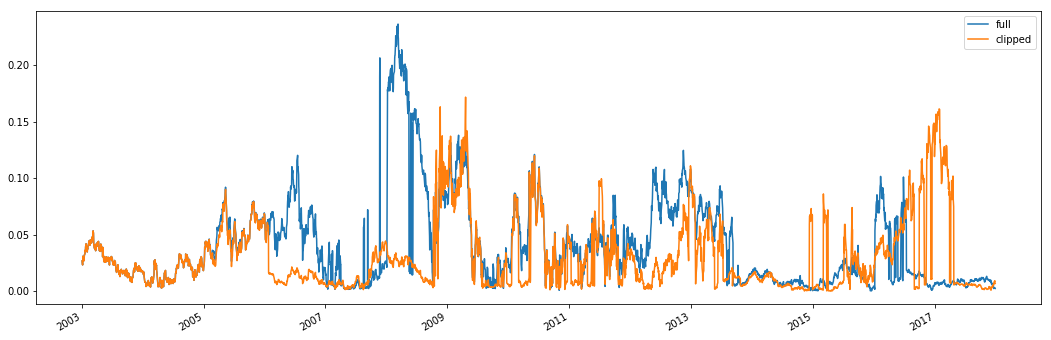

In [23]:
ax = base_full['test_performances'].std(axis=1).rename("full").plot(figsize=(18,6))
base_clipped['test_performances'].std(axis=1).rename("clipped").plot(ax=ax)
plt.legend()
plt.show()

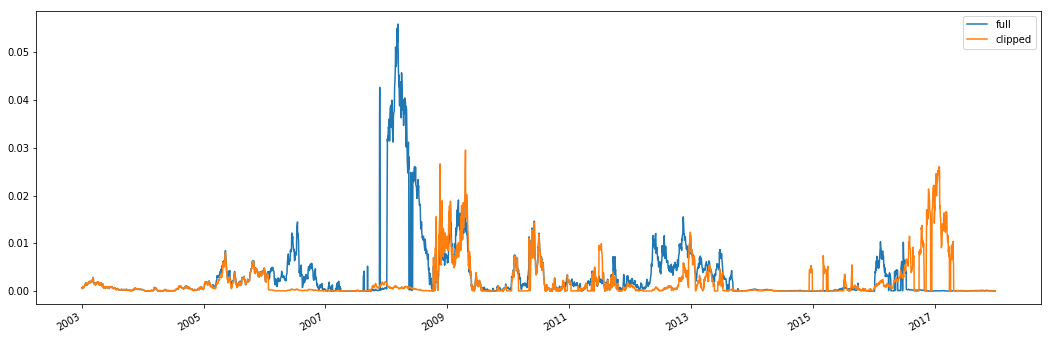

In [24]:
ax = base_full['test_performances'].var(axis=1).rename("full").plot(figsize=(18,6))
base_clipped['test_performances'].var(axis=1).rename("clipped").plot(ax=ax)
plt.legend()
plt.show()

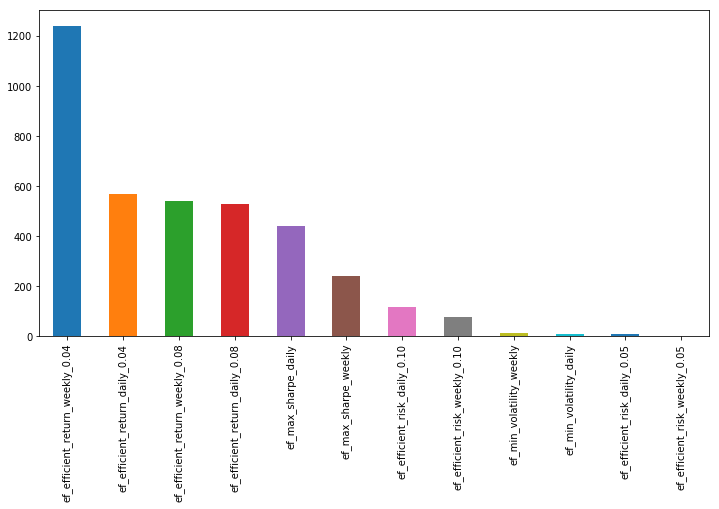

In [25]:
base_full['optimal_portfolios'].value_counts().plot(kind='bar', figsize=(12,6))
plt.show()

### Training - dataset merging

In [26]:
base_df = pd.concat([
    base_full['allocacations'], 
    base_clipped['allocacations'],
    base_full['features'],
    base_clipped['features']
], axis=1)
base_df.shape

(3793, 360)

In [27]:
train_df = funds_df.join(base_df)
train_df.isna().sum().value_counts()

1008    320
1010     20
1009     20
0         7
dtype: int64

In [28]:
train_df.dropna(inplace=True)
train_df.index.min(), train_df.index.max()

(Timestamp('2003-01-03 00:00:00'), Timestamp('2017-12-29 00:00:00'))

In [29]:
dates_df = pd.get_dummies(train_df.index.weekofyear)
dates_df.index = train_df.index
train_df = train_df.join(dates_df, rsuffix='_woy')
train_df['year'] = (train_df.index.year-train_df.index.year.min()) \
                 / (train_df.index.year.max() - train_df.index.year.min()) \
                 + 1
train_df.shape, train_df.isna().sum().sum()

((3790, 421), 0)

In [30]:
top_returns_df = pd.concat([
    base_full['test_performances'].loc[train_df.index].max(axis=1),
    base_clipped['test_performances'].loc[train_df.index].max(axis=1)
], axis=1).max(axis=1)

### Training - loss function

In [31]:
def relative_returns_loss(epsilon=1e-12):
    def loss_function(outputs, future_fund_values, top_base_returns):
        model_portfolio_values = torch.sum(outputs * future_fund_values, dim=1)
        model_portfolio_returns = (model_portfolio_values[-1] - model_portfolio_values[0])\
                                / (model_portfolio_values[0] + epsilon)
        return torch.exp(top_base_returns-model_portfolio_returns)
    return loss_function

In [32]:
# sandbox for examining the loss function
sample_allocation = torch.zeros(7)
sample_allocation[4] = 1

sample_timeframe = torch.Tensor(funds_df.iloc[750:900].values)

relative_returns_loss()(sample_allocation, sample_timeframe, 3.5)

tensor(31.9643)

### Training - network improvement

In [33]:
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lstm_layers=2, dropout_pct=0.25):
        super(BasicLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.fc01 = nn.Linear(input_dim, input_dim)
        self.fc02 = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(dropout_pct)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=lstm_layers)
        self.fcf1 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fcf2 = nn.Linear(hidden_dim*2, output_dim)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.zeros(self.lstm_layers, 1, self.hidden_dim).cuda(cuda_device),
                torch.zeros(self.lstm_layers, 1, self.hidden_dim).cuda(cuda_device))

    def forward(self, tensor):
        tensor = self.fc01(tensor)
        tensor = torch.sigmoid(self.dropout(self.fc02(tensor)))
        tensor, self.hidden = self.lstm(
            tensor.view(len(tensor), 1, -1), 
            self.hidden
        )
        tensor = torch.log_softmax(tensor, dim=2)
        tensor = self.fcf1(tensor)
        tensor = self.fcf2(tensor)
        tensor = torch.softmax(tensor[-1], dim=1)
        return tensor

### Training - parameters & setup

In [34]:
n_epochs = 5
lr = 0.02137
model_hidden_dim = 420
min_seq_len = 3*year_days
val_set_len = 2*year_days
loss_calc_batch = year_days  # average loss for this number of samples will be printed

In [35]:
model = BasicLSTM(train_df.shape[1], model_hidden_dim, 7).cuda(cuda_device)
loss_function = relative_returns_loss()
optimizer = optim.Adam(model.parameters(), lr=lr)

### Training - loop

tensor(1.0308, device='cuda:0')
tensor(1.1054, device='cuda:0')
tensor(1.1632, device='cuda:0')
tensor(1.0323, device='cuda:0')
tensor(1.0649, device='cuda:0')
tensor(1.0665, device='cuda:0')
tensor(1.1104, device='cuda:0')
tensor(1.0887, device='cuda:0')
tensor(1.0323, device='cuda:0')
tensor(1.0621, device='cuda:0')


504it [01:03,  7.35it/s]


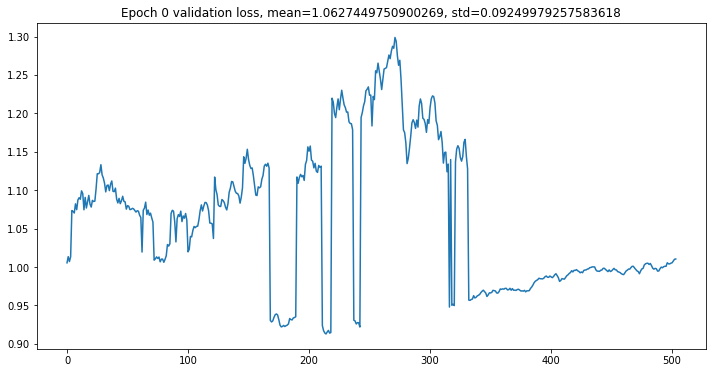

tensor(1.0308, device='cuda:0')
tensor(1.1054, device='cuda:0')
tensor(1.1632, device='cuda:0')
tensor(1.0323, device='cuda:0')
tensor(1.0649, device='cuda:0')
tensor(1.0665, device='cuda:0')
tensor(1.1104, device='cuda:0')
tensor(1.0887, device='cuda:0')
tensor(1.0323, device='cuda:0')
tensor(1.0621, device='cuda:0')


504it [01:03,  7.38it/s]


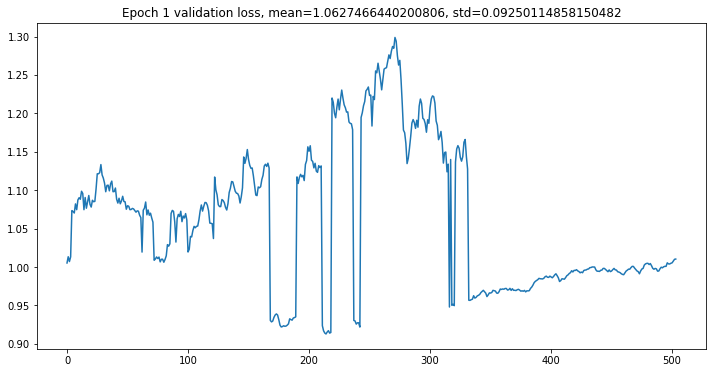

tensor(1.0308, device='cuda:0')
tensor(1.1054, device='cuda:0')
tensor(1.1632, device='cuda:0')
tensor(1.0323, device='cuda:0')
tensor(1.0649, device='cuda:0')
tensor(1.0665, device='cuda:0')
tensor(1.1104, device='cuda:0')
tensor(1.0887, device='cuda:0')
tensor(1.0323, device='cuda:0')
tensor(1.0621, device='cuda:0')


504it [01:02,  7.92it/s]


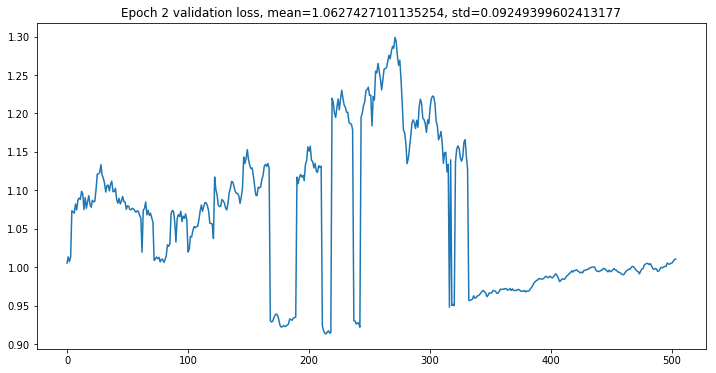

tensor(1.0308, device='cuda:0')
tensor(1.1054, device='cuda:0')
tensor(1.1632, device='cuda:0')
tensor(1.0323, device='cuda:0')
tensor(1.0649, device='cuda:0')
tensor(1.0665, device='cuda:0')
tensor(1.1104, device='cuda:0')
tensor(1.0887, device='cuda:0')
tensor(1.0323, device='cuda:0')
tensor(1.0621, device='cuda:0')


504it [01:02,  7.44it/s]


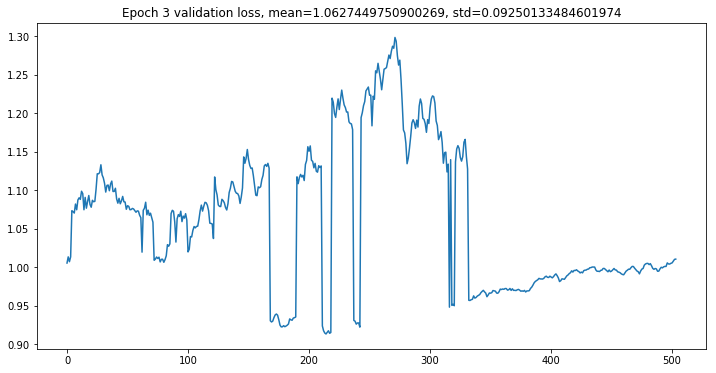

tensor(1.0308, device='cuda:0')
tensor(1.1054, device='cuda:0')
tensor(1.1632, device='cuda:0')
tensor(1.0323, device='cuda:0')
tensor(1.0649, device='cuda:0')
tensor(1.0665, device='cuda:0')
tensor(1.1104, device='cuda:0')
tensor(1.0887, device='cuda:0')
tensor(1.0323, device='cuda:0')
tensor(1.0621, device='cuda:0')


504it [01:02,  7.37it/s]


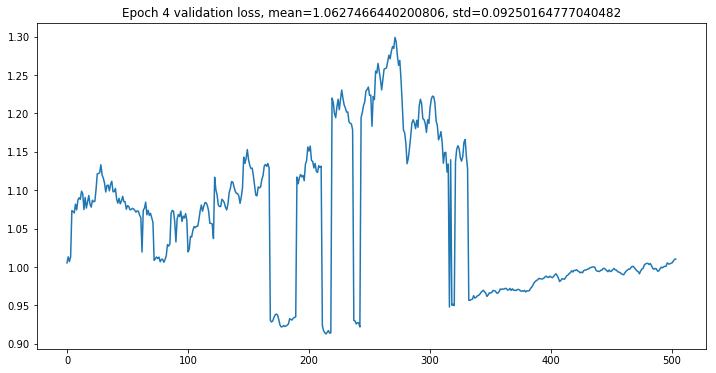

In [36]:
for epoch in range(n_epochs):
    # training
    losses = torch.zeros(loss_calc_batch).cuda(cuda_device)
    top_base_returns = torch.Tensor(
        top_returns_df.values
    ).cuda(cuda_device)
    for target_idx in range(min_seq_len, len(train_df)-val_set_len):
        sequence = torch.Tensor(
            train_df.iloc[:target_idx].values
        ).cuda(cuda_device)
        future = torch.Tensor(
            train_df[fund_colnames].iloc[target_idx:target_idx+year_days].values
        ).cuda(cuda_device)
        # reset state
        model.zero_grad()
        model.hidden = model.init_hidden()
        # forward
        pred = model(sequence)
        # backprop
        loss = loss_function(pred, future, top_base_returns[target_idx])
        optimizer.step()
        loss.backward()
        with torch.no_grad():
            losses[(target_idx-min_seq_len) % loss_calc_batch] = loss
            if ((target_idx-min_seq_len) % loss_calc_batch) == loss_calc_batch-1:
                print(losses.mean())
    # validation
    with torch.no_grad():
        losses = torch.zeros(val_set_len).cuda(cuda_device)
        for i, target_idx in tqdm(enumerate(range(len(train_df)-val_set_len, len(train_df)))):
            sequence = torch.Tensor(
                train_df.iloc[:target_idx].values
            ).cuda(cuda_device)
            future = torch.Tensor(
                train_df[fund_colnames].iloc[target_idx:target_idx+year_days].values
            ).cuda(cuda_device)
            pred = model(sequence)
            losses[i] = loss_function(pred, future, top_base_returns[target_idx])
        pd.Series(losses.cpu().numpy()).plot(
            title=f"Epoch {epoch} validation loss, mean={losses.mean()}, std={losses.std()}",
            figsize=(12,6)
        )
        plt.show()